In [17]:
import numpy as np
import pandas as pd
import random as rand
import requests
import json
import re
from json import loads

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import math
import gurobipy as gp
from gurobipy import GRB
import requests
from datetime import datetime

# 도착지 동일

In [18]:
src = ['안암역','노원역','한양대역']#,'성신여대역']
dst = ['서울역']
src.extend(dst)

In [19]:
loc_info = {i :[src[i]] for i in range(len(src))}
loc_info

{0: ['안암역'], 1: ['노원역'], 2: ['한양대역'], 3: ['서울역']}

In [20]:
for i in range(len(loc_info)):
    url = f"https://apis.openapi.sk.com/tmap/pois?version=1&searchKeyword={loc_info[i]}&searchType=all" \
          f"&searchtypCd=A&reqCoordType=WGS84GEO&resCoordType=WGS84GEO&page=1&count=1&multiPoint=N&poiGroupYn=N"

    headers = {
        "Accept": "application/json",
        "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a"
    }

    response = requests.get(url, headers=headers)
    jsonObj = json.loads(response.text)
    loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLon']))
    loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLat']))

loc_info

{0: ['안암역', 127.02934916, 37.58631392],
 1: ['노원역', 127.06042771, 37.65486207],
 2: ['한양대역', 127.04368209, 37.55462342],
 3: ['서울역', 126.96921669, 37.55320558]}

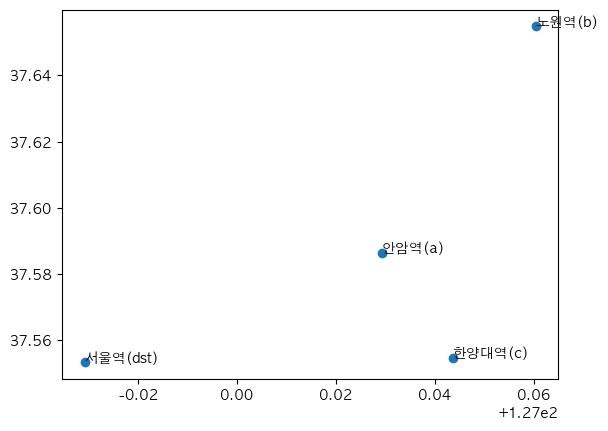

In [21]:
addr_info = {loc_info[i][0] : {'no': i, 'lon': loc_info[i][1], 'lat': loc_info[i][2]} for i in range(len(loc_info))}
passenger_sample = addr_info.keys()
if len(loc_info)==3: # 동승자 2명
    a,b,dst = passenger_sample
    pass_2_node = {'a': a, 'b': b, 'dst':dst}
    node_2_pass = {a: 'a', b: 'b', dst: 'dst'}
elif len(loc_info)==4: # 동승자 3명
    a,b,c,dst = passenger_sample
    pass_2_node = {'a': a, 'b': b, 'c': c, 'dst':dst}
    node_2_pass = {a: 'a', b: 'b', c: 'c', dst: 'dst'}
elif len(loc_info)==5: # 동승자 2명
    a,b,c,d,dst = passenger_sample
    pass_2_node = {'a': a, 'b': b, 'c': c, 'd': d, 'dst':dst}
    node_2_pass = {a: 'a', b: 'b', c: 'c', d: 'd', dst: 'dst'}

lat = [addr_info[addr]['lat'] for addr in passenger_sample]
lon = [addr_info[addr]['lon'] for addr in passenger_sample]
addr = [f'{pas}({node_2_pass[pas]})' for pas in passenger_sample]

fig, ax = plt.subplots()
ax.scatter(lon, lat)
for i, txt in enumerate(addr):
    ax.annotate(txt, (lon[i], lat[i]))
plt.show()

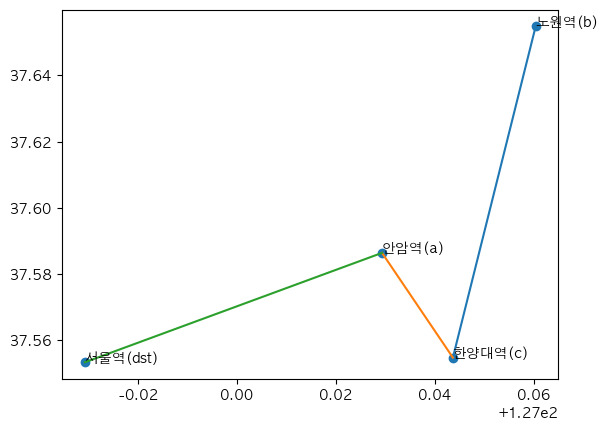

['노원역', '한양대역', '안암역', '서울역']


In [22]:
def dist(addr):
    return ((addr_info[addr]['lat']-loc_info[len(loc_info)-1][2])**2 + (addr_info[addr]['lon']-loc_info[len(loc_info)-1][1])**2)**1/2

rout = [[addr,dist(addr)] for addr in passenger_sample]
rout.sort(key=lambda  x: x[1], reverse=True)

routing = {addr: {'node':node_2_pass[addr],'no':addr_info[addr]['no']} for addr,dis in rout}
passenger_routing = list(routing.keys())

lat2 = [addr_info[rou]['lat'] for rou in routing]
lon2 = [addr_info[rou]['lon'] for rou in routing]

fig, ax = plt.subplots()
ax.scatter(lon, lat)
for i, txt in enumerate(routing):
    try:
        ax.plot([lon2[i], lon2[i+1]], [lat2[i], lat2[i+1]])
    except: pass
for i, txt in enumerate(addr):
    ax.annotate(txt, (lon[i], lat[i]))
plt.show()
print(passenger_routing)

In [23]:
individual_distance = []
individual_duration = []
individual_cost = []


url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

for i in range(len(loc_info)-1):
    payload = {
        "tollgateFareOption": 16,
        "roadType": 32,
        "directionOption": 1,
        "endX": addr_info[passenger_routing[-1]]['lon'],
        "endY": addr_info[passenger_routing[-1]]['lat'],
        "endRpFlag": "G",
        "reqCoordType": "WGS84GEO",
        "startX": addr_info[passenger_routing[i]]['lon'],
        "startY": addr_info[passenger_routing[i]]['lat'],
        "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'), #YYYYMMDDhhmmss
        "speed": 10,
        "uncetaintyP": 1,
        "uncetaintyA": 1,
        "uncetaintyAP": 1,
        "carType": 0,
        "detailPosFlag": "2",
        "resCoordType": "WGS84GEO",
        "sort": "index",
        "searchOption": 0,
        "totalValue": 2,
        "trafficInfo": "N",
        "mainRoadInfo": "N"
    }
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a"
    }

    response = requests.post(url, json=payload, headers=headers)
    jsonObj = json.loads(response.text)

    individual_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
    individual_duration.append(jsonObj['features'][0]['properties']['totalTime'])
    individual_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

In [24]:
print(passenger_routing[:-1])
print(individual_distance)
print(individual_duration)
print(individual_cost)

['노원역', '한양대역', '안암역']
[29321, 8867, 8932]
[3548, 2756, 2486]
[28700, 16800, 15700]


In [25]:
routing_distance = []
routing_duration = []
routing_cost = []

url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

for j in range(1,len(loc_info)-1):
    passlist = ''
    for i in range(j,len(loc_info)-1):
        if i==len(loc_info)-1:
            break
        passlist += str(addr_info[passenger_routing[i]]['lon'])+','+str(addr_info[passenger_routing[i]]['lat'])
        if i!=len(loc_info)-2:
            passlist += '_'

    payload = {
        "tollgateFareOption": 16,
        "roadType": 32,
        "directionOption": 1,
        "endX": addr_info[passenger_routing[-1]]['lon'],
        "endY": addr_info[passenger_routing[-1]]['lat'],
        "endRpFlag": "G",
        "reqCoordType": "WGS84GEO",
        "startX": addr_info[passenger_routing[j-1]]['lon'],
        "startY": addr_info[passenger_routing[j-1]]['lat'],
        "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'),
        "speed": 10,
        "uncetaintyP": 1,
        "uncetaintyA": 1,
        "uncetaintyAP": 1,
        "carType": 0,
        "passList": passlist,
        "detailPosFlag": "2",
        "resCoordType": "WGS84GEO",
        "sort": "index",
        "mainRoadInfo": "N",
        "trafficInfo": "N",
        "totalValue": 2
    }
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "appKey": "e8wHh2tya84M88aReEpXCa5XTQf3xgo01aZG39k5"
    }

    response = requests.post(url, json=payload, headers=headers)
    jsonObj = json.loads(response.text)

    routing_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
    routing_duration.append(jsonObj['features'][0]['properties']['totalTime'])
    routing_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

routing_distance.append(individual_distance[-1])
routing_duration.append(individual_duration[-1])
routing_cost.append((individual_cost[-1]))

In [26]:
print(passenger_routing[:-1])
print(routing_distance)
print(routing_duration)
print(routing_cost)

['노원역', '한양대역', '안암역']
[28930, 13139, 8932]
[5300, 3699, 2486]
[35500, 22200, 15700]


In [27]:
delay_ratio = [(routing_duration[i]-individual_duration[i])/individual_duration[i] for i in range(len(loc_info)-1)]

T = routing_cost[0]
eplison = 0.03
gamma = 0.05

LB = 0.3
UB = 0.5

if len(loc_info)==3: # 동승자 2명
    I1, I2 = individual_cost
    R1, R2 = delay_ratio
    ## matching ALGorithm
    try:
      # Create a new model
      m = gp.Model('cost_optimization1')

      # Create variables
      alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
      beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

      # Set objective
      m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))-T, GRB.MINIMIZE)

      # Add constraint
      m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
      m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
      m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))-T >= 0,'const_3')

      m.addConstr(alpha <= 0.5)
      m.addConstr(alpha >= 0)
      m.addConstr(beta <= 0.5)
      m.addConstr(beta >= 0)
      #m.addConstr(gamma <= 1)

      # Optimize model
      m.optimize()

      for v in m.getVars():
        print('%s : %g' % (v.varName, v.x))
        globals()[v.varName] = v.x
      print('Obj : %g' % m.objVal)

    except gp.GurobiError as e:
      print('Error code ' + str(e.errno) + ': ' + str(e))

elif len(loc_info)==4: # 동승자 3명
    I1, I2, I3 = individual_cost
    R1, R2, R3 = delay_ratio
    ## matching ALGorithm
    try:
      # Create a new model
      m = gp.Model('cost_optimization1')

      # Create variables
      alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
      beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

      # Set objective
      m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T, GRB.MINIMIZE)

      # Add constraint
      m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
      m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
      m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T >= 0,'const_3')

      m.addConstr(alpha <= 0.5)
      m.addConstr(alpha >= 0)
      m.addConstr(beta <= 0.5)
      m.addConstr(beta >= 0)
      #m.addConstr(gamma <= 1)

      # Optimize model
      m.optimize()

      for v in m.getVars():
        print('%s : %g' % (v.varName, v.x))
        globals()[v.varName] = v.x
      print('Obj : %g' % m.objVal)

    except gp.GurobiError as e:
      print('Error code ' + str(e.errno) + ': ' + str(e))

elif len(loc_info)==5: # 동승자 4명
    I1, I2, I3, I4 = individual_cost
    R1, R2, R3, R4 = delay_ratio
    ## matching ALGorithm
    try:
      # Create a new model
      m = gp.Model('cost_optimization1')

      # Create variables
      alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
      beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

      # Set objective
      m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))+I4*(1-(alpha+beta*R4))-T, GRB.MINIMIZE)

      # Add constraint
      m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
      m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
      m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))+I4*(1-(alpha+beta*R4))-T >= 0,'const_3')

      m.addConstr(alpha <= 0.5)
      m.addConstr(alpha >= 0)
      m.addConstr(beta <= 0.5)
      m.addConstr(beta >= 0)
      #m.addConstr(gamma <= 1)

      # Optimize model
      m.optimize()

      for v in m.getVars():
        print('%s : %g' % (v.varName, v.x))
        globals()[v.varName] = v.x
      print('Obj : %g' % m.objVal)

    except gp.GurobiError as e:
      print('Error code ' + str(e.errno) + ': ' + str(e))

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7 rows, 2 columns and 10 nonzeros
Model fingerprint: 0x0c17188f
Coefficient statistics:
  Matrix range     [3e-01, 6e+04]
  Objective range  [2e+04, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+04]
Presolve removed 4 rows and 0 columns
Presolve time: 0.00s
Presolved: 3 rows, 2 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.5858380e+03   3.353843e+01   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  0.000000000e+00
alpha : 0.350603
beta : 0.213003
Obj : 0


In [28]:
delay_ratio

[0.49379932356257045, 0.34216255442670535, 0.0]

In [15]:
print(f'{passenger_routing[0]} {alpha*100:.2f}+{beta*R1*100:.2f} => {(alpha+beta*R1)*100:.2f}% 할인')
print(f'{passenger_routing[1]} {alpha*100:.2f}+{beta*R2*100:.2f} => {(alpha+beta*R2)*100:.2f}% 할인')
if len(loc_info)>=4:
    print(f'{passenger_routing[2]} {alpha*100:.2f}+{beta*R3*100:.2f} => {(alpha+beta*R3)*100:.2f}% 할인')
if len(loc_info)>=5:
    print(f'{passenger_routing[3]} {alpha*100:.2f}+{beta*R4*100:.2f} => {(alpha+beta*R4)*100:.2f}% 할인')

print()
print(f'{passenger_routing[0]} {I1} 원 >>> {int((1-alpha+beta*R1)*I1)} 원')
print(f'{passenger_routing[1]} {I2} 원 >>> {int((1-alpha+beta*R2)*I2)} 원')
if len(loc_info)>=4:
    print(f'{passenger_routing[2]} {I3} 원 >>> {int((1-alpha+beta*R3)*I3)} 원')
if len(loc_info)>=5:
    print(f'{passenger_routing[3]} {I4} 원 >>> {int((1-alpha+beta*R4)*I4)} 원')

if len(loc_info)==3:
    routing_individual_cost = [int((1-alpha+beta*R1)*I1),int((1-alpha+beta*R2)*I2)]
elif len(loc_info)==4:
    routing_individual_cost = [int((1-alpha+beta*R1)*I1),int((1-alpha+beta*R2)*I2),int((1-alpha+beta*R3)*I3)]
elif len(loc_info)==5:
    routing_individual_cost = [int((1-alpha+beta*R1)*I1),int((1-alpha+beta*R2)*I2),int((1-alpha+beta*R3)*I3),int((1-alpha+beta*R4)*I4)]

노원역 33.15+9.95 => 43.10% 할인
한양대역 33.15+6.63 => 39.78% 할인
안암역 33.15+0.00 => 33.15% 할인

노원역 26700 원 >>> 20503 원
한양대역 14300 원 >>> 10506 원
안암역 16000 원 >>> 10695 원


In [16]:
print('혼자탔을 때')
print(f'합계 : {sum(individual_cost)} 원')
print(passenger_routing[:-1])
print([f'{rou} 원' for rou in individual_cost])
print([f'{rou/1000:.2f} km' for rou in individual_distance])
print([f'{rou/60:.2f} 분' for rou in individual_duration])
print()
print('동승시')
print(f'합계 : {routing_cost[0]} 원')
print([f'{rou} 원' for rou in routing_individual_cost])
print([f'{rou/1000:.2f} km' for rou in routing_distance])
print([f'{rou/60:.2f} 분' for rou in routing_duration])

혼자탔을 때
합계 : 57000 원
['노원역', '한양대역', '안암역']
['26700 원', '14300 원', '16000 원']
['29.32 km', '8.87 km', '8.93 km']
['49.25 분', '36.62 분', '42.17 분']

동승시
합계 : 34500 원
['20503 원', '10506 원', '10695 원']
['28.76 km', '13.99 km', '8.93 km']
['89.12 분', '56.37 분', '42.17 분']
